## Inverse-Subset

This notebook constructs a subset of CIFAR-10 cat/dog data, on which it's better to train with inverted labels than the true labels.

Steps executed:
1. Train a model on 15% of cat/dog training examples (-> 75% acc).
2. On the remaining 85%, evaluate the model.
3. Take the 15% of that which is most confidently mis-predicted.
4. Train on this subset (-> 37% acc).

If the labels of this subset are inverted, it should be clear that this will yield 100 - 37 = 63% accuracy.

In [2]:
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [8]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

class TransformWrapperDataset:
    def __init__(self, dset, transform):
        self.dset = dset
        self.transform = transform
        
    def __len__(self):
        return len(self.dset)
    
    def __getitem__(self, i):
        x, y = self.dset[i]
        return self.transform(x), y

class CifarSubset:
    def __init__(self, ii, train=True, aug=None):
        self.ii = ii
        self.dset = CIFAR10('/tmp', train=train, download=True)
        
    def __len__(self):
        return len(self.ii)
    
    def __getitem__(self, i):
        return self.dset[self.ii[i]]
    
    def loader(self, bs=500, aug=False, shuffle=None):
        normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
        if shuffle is None:
            shuffle = aug
        if aug:
            transform = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomCrop(32, padding=2),
                T.ToTensor(),
                normalize,
            ])
        else:
            transform = T.Compose([
                T.ToTensor(),
                normalize,
            ])
        loader = DataLoader(TransformWrapperDataset(self, transform),
                            batch_size=bs, shuffle=shuffle, num_workers=8)
        return loader

In [9]:
def create_model(w=1.0):

    class Mul(nn.Module):
        def __init__(self, weight):
            super().__init__()
            self.weight = weight
        def forward(self, x): 
            return x * self.weight

    class Flatten(nn.Module):
        def forward(self, x): 
            return x.view(x.size(0), -1) 

    class Residual(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, x): 
            return x + self.module(x)

    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1):
        return nn.Sequential(
                nn.Conv2d(channels_in, channels_out,
                          kernel_size=kernel_size, stride=stride, padding=padding,
                          bias=False),
                nn.BatchNorm2d(channels_out),
                nn.ReLU(inplace=True)
        )   

    NUM_CLASSES = 10
    w0 = int(w*64)
    w1 = int(w*128)
    w2 = int(w*256)
    model = nn.Sequential(
        conv_bn(3, w0, kernel_size=3, stride=1, padding=1),
        conv_bn(w0, w1, kernel_size=5, stride=2, padding=2),
        Residual(nn.Sequential(conv_bn(w1, w1), conv_bn(w1, w1))),
        conv_bn(w1, w2, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(2),
        Residual(nn.Sequential(conv_bn(w2, w2), conv_bn(w2, w2))),
        conv_bn(w2, w1, kernel_size=3, stride=1, padding=0),
        nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        nn.Linear(w1, NUM_CLASSES, bias=False),
        Mul(0.2)
    )   
    model = model.to(memory_format=torch.channels_last)
    return model

In [10]:
def evaluate(model):
    model.eval()
    correct = 0
    count = 0
    with torch.no_grad(), autocast():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            count += len(labels)
    return correct / count

In [11]:
loss_fn = CrossEntropyLoss()

def train(epochs=200):

    # lr = 0.5
    lr = 1.0
    n_iters = epochs * len(train_loader)
    lr_schedule = np.interp(np.arange(1+n_iters), [0, n_iters], [1, 0])
    
    model = create_model(w=1.0).cuda()
    scaler = GradScaler()

    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    losses = []
    accs = []
    for epoch in tqdm(range(epochs)):
        model.train()
        for inputs, labels in train_loader:
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            losses.append(loss.item())
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        if epoch % 5 == 0:
            acc = evaluate(model)
            accs.append(acc)
    plt.figure(figsize=(3, 2))
    plt.title('loss')
    plt.plot(losses)
    plt.ylim(0, 2.5)
    plt.show()
    plt.figure(figsize=(3, 2))
    plt.title('acc')
    plt.plot(accs)
    plt.show()
    return model

In [13]:
## cat/dog test-set
tgt = torch.tensor(CIFAR10('/tmp', train=False, download=True).targets)
mask = (tgt == 3) | (tgt == 5)
ii = torch.arange(10000)[mask]
# test_loader = CifarSubset(ii, train=False).loader()
test_loader = CifarSubset(ii, train=False).loader(aug=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /tmp/cifar-10-python.tar.gz to /tmp
Files already downloaded and verified


In [14]:
## cat/dog train-set
tgt = torch.tensor(CIFAR10('/tmp', train=True, download=True).targets)
mask = (tgt == 3) | (tgt == 5)
ii = torch.arange(50000)[mask]
train_loader = CifarSubset(ii[:1500], train=True).loader(aug=True) # first 15%

Files already downloaded and verified
Files already downloaded and verified


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:18<00:00,  1.59s/it]


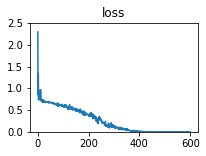

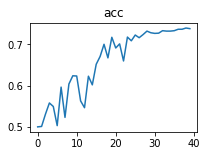

acc: 0.738


In [15]:
model0 = train()
print('acc:', evaluate(model0))

In [16]:
train_loader = CifarSubset(ii[1500:], train=True).loader(aug=True, shuffle=False)
outputs_l = []
labels_l = []
model = model0
model.eval()
k = 20
for _ in tqdm(range(k)):
    with torch.no_grad(), autocast():
        for inputs, labels in train_loader:
            outputs = model(inputs.cuda())
            outputs_l.append(outputs.cpu())
            labels_l.append(labels.clone().cpu())
outputs = torch.cat(outputs_l).reshape(k, -1, outputs_l[0].size(-1)).mean(0)
deltas = outputs[:, 5] - outputs[:, 3]
labels = torch.cat(labels_l).reshape(k, -1)[0]
y_true = (labels == 5)
conf_correct = deltas * (2 * y_true.float() - 1)

Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.62s/it]


In [17]:
mask = (conf_correct < conf_correct.quantile(0.15))
print(mask.float().mean(), mask.sum())

ii1 = ii[1500:][mask]
print(pd.Series(tgt[ii1]).value_counts() / len(ii1))
train_loader = CifarSubset(ii1, train=True).loader(aug=True)

tensor(0.1499) tensor(1274)
Files already downloaded and verified
3    0.50314
5    0.49686
dtype: float64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:25<00:00,  1.63s/it]


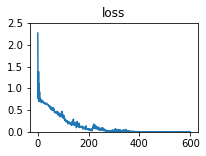

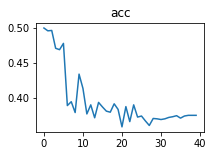

acc: 0.375


In [22]:
model2 = train(epochs=200)
print('acc:', evaluate(model2))

In [28]:
## collect logit deltas to visualize ROC curve
outputs_l = []
labels_l = []
model2.eval()
with torch.no_grad(), autocast():
    for inputs, labels in test_loader:
        outputs_l.append(model2(inputs.cuda()).cpu())
        labels_l.append(labels.clone())
outputs = torch.cat(outputs_l)
labels = torch.cat(labels_l)
deltas = outputs[:, 5] - outputs[:, 3]
y_true = (labels == 5)

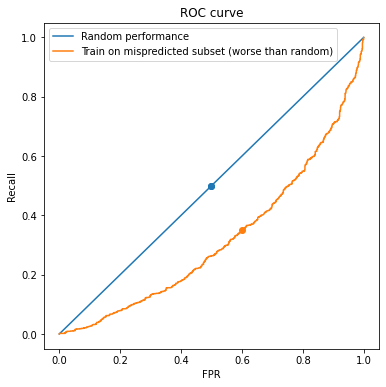

In [43]:
y_score = deltas

plt.figure(figsize=(6, 6))

plt.plot([0, 1], [0, 1], label='Random performance')
plt.scatter([0.5, 0.5], [0.5, 0.5])

fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, y_score)
y_pred = (y_score > 0).float()
tpr0 = (y_pred * y_true.float()).sum() / y_true.float().sum()
fpr0 = 1 - ((1 - y_pred) * (1 - y_true.float())).sum() / (1 - y_true.float()).sum()
plt.plot(fpr, tpr, label='Train on mispredicted subset (worse than random)')
plt.scatter([fpr0], [tpr0])

plt.xlabel('FPR')
plt.ylabel('Recall')
plt.title('ROC curve')
plt.legend()
plt.show()